In [1]:
import functions
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.signal import  filtfilt, butter, iirnotch, savgol_filter, find_peaks
from sklearn.decomposition import FastICA as skFastICA
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB

In [2]:
no_ica_chans = 18
fs=1000
span = 3000
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 

In [3]:
def bandpass_filter(dd, order=5):
    b, a = butter(order, [2, 99], btype='band', fs=1000)
    b_notch, a_notch = iirnotch(50, 40, fs=1000)
    data = deepcopy(dd)
    for i in range(1,data.shape[1]):
        data[:,i] = filtfilt(b, a, data[:,i])
        data[:,i] = filtfilt(b_notch, a_notch, data[:,i])
    return data

In [4]:
dd = functions.array_from_TDMSgroup("patients/P045/P045_S01_D2024-04-25_G36.tdms", "R004")
filtered_data = bandpass_filter(dd)

### Block 1: FastICA with 18 components --> S_ (sources), A_(mixing matrix)

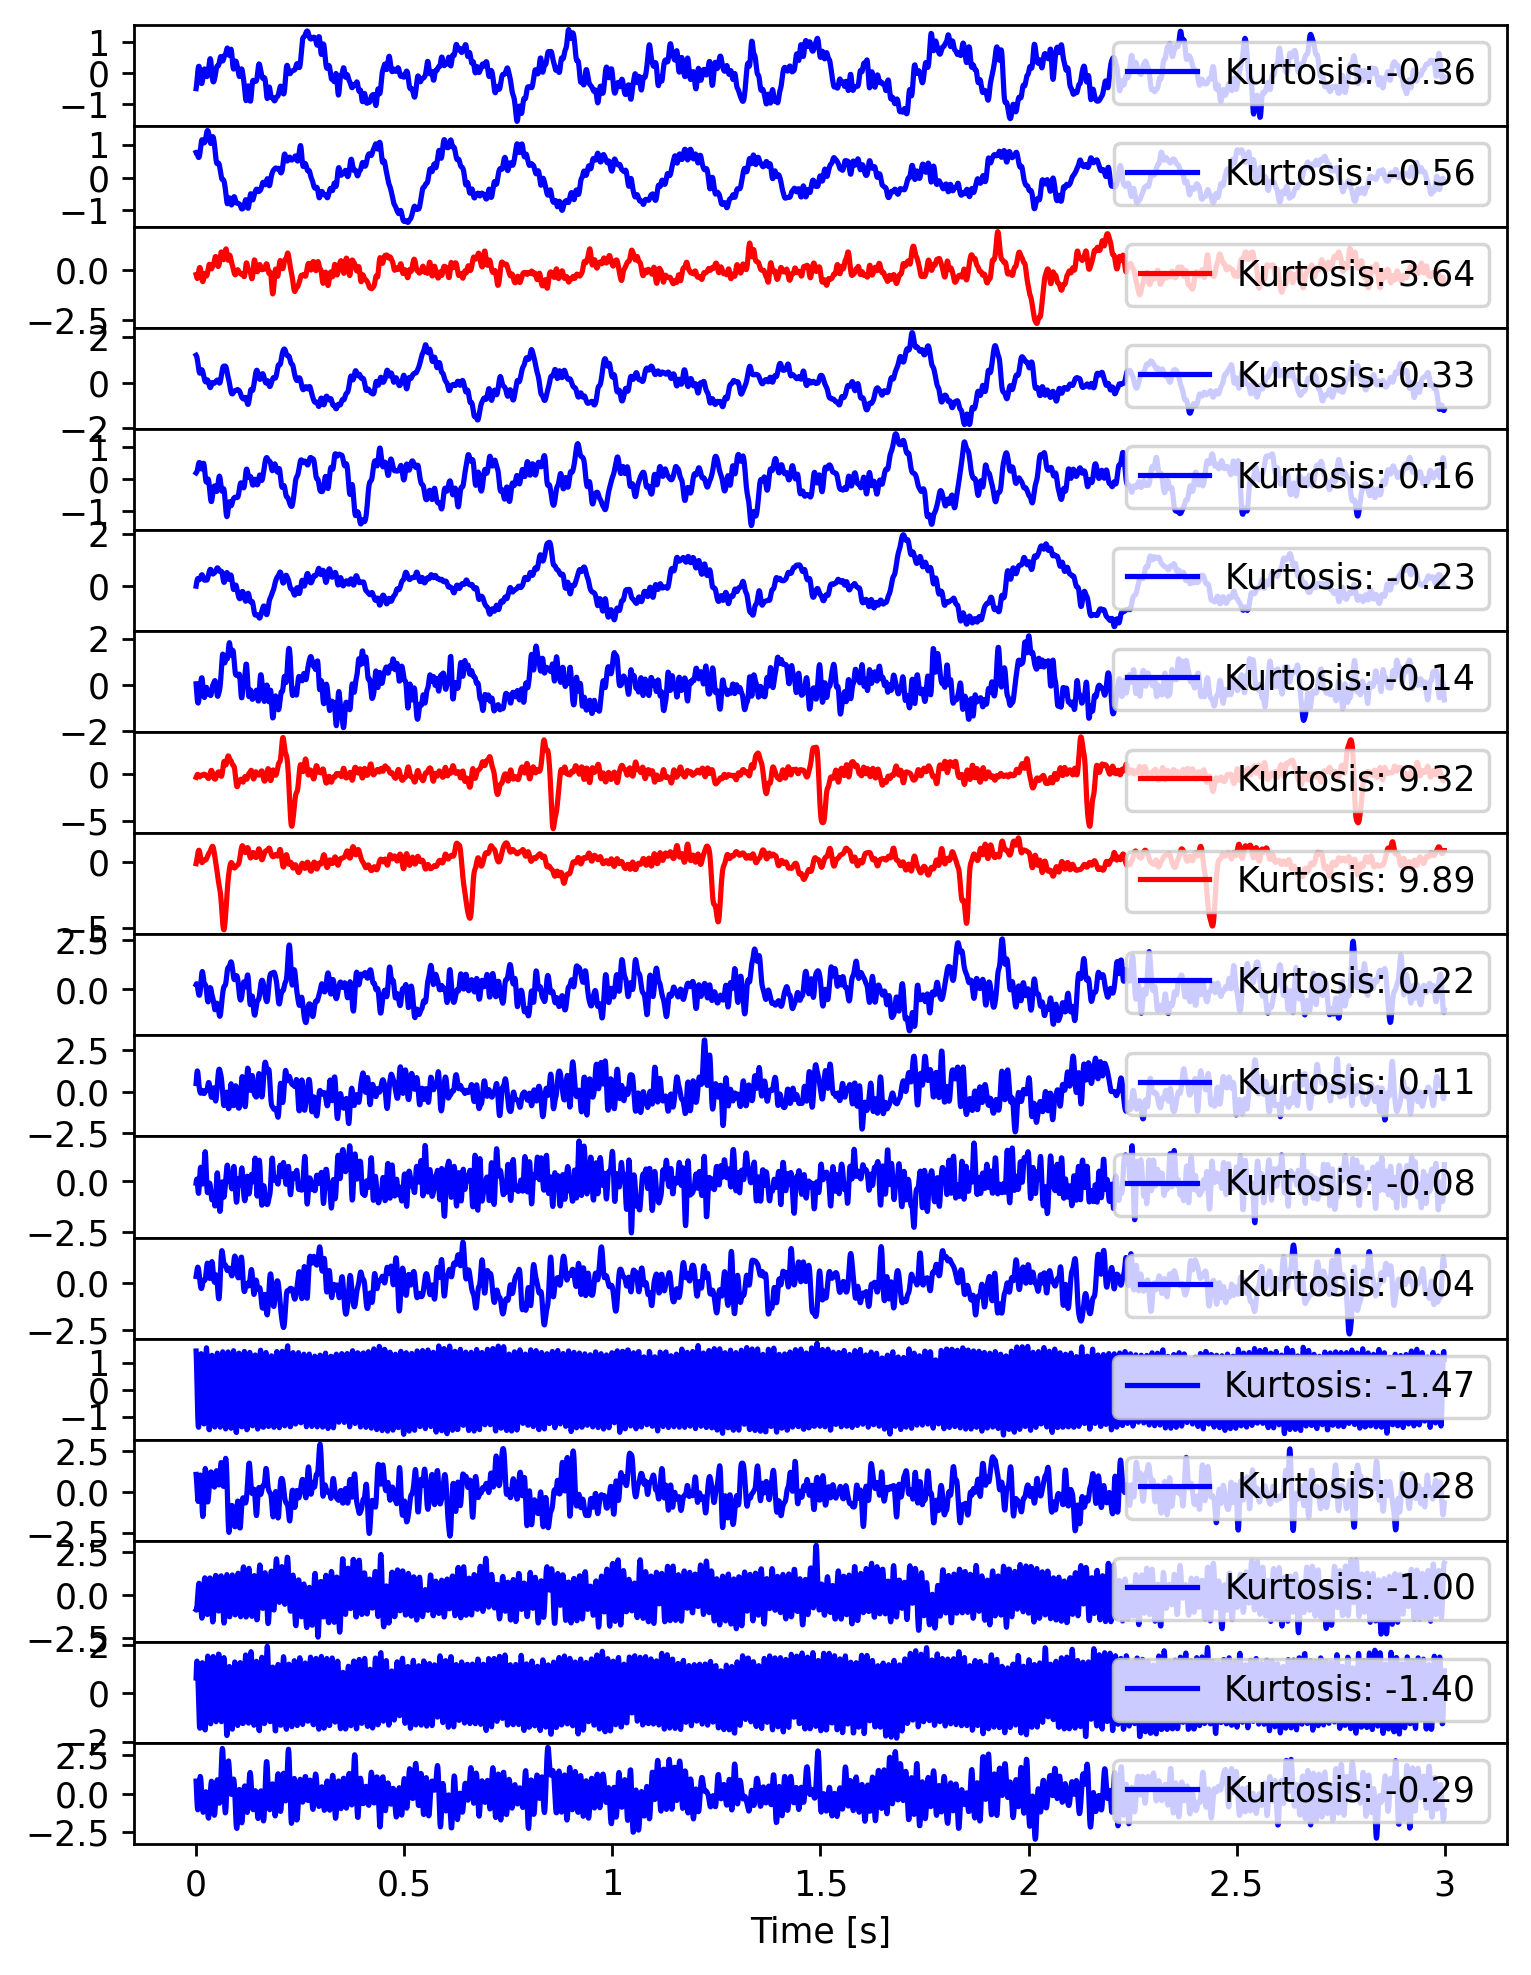

In [5]:
ica = skFastICA(n_components=no_ica_chans,algorithm='deflation',max_iter=4000,fun='logcosh',tol=1e-5)
S_ = ica.fit_transform(filtered_data[5000:,1:])
A_ = ica.mixing_

kurtosis_values = [stats.kurtosis(S_[offset:(offset + span), j]) for j in range(no_ica_chans)]

# Plot
fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(no_ica_chans):
    ax[j].plot(S_[offset:(offset + span), j], label=f'Kurtosis: {kurtosis_values[j]:.2f}', color='red' if kurtosis_values[j] > 1.8 else 'blue')
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

### Block 2: kurtosis thresholding, from what I observe the kurtosis values higher than 1.7 are generally in a peaky shape and they are either maternal or fetal component, see mixing_analysis.ipynb for this.

In [8]:
def kurtosis_thresholding(source_matrix, threshold): # while giving the source_matrix, offset and span also be defined
    kurtosis_values = [stats.kurtosis(source_matrix[:, j]) for j in range(source_matrix.shape[1])]
    selected_indices = [i for i, k in enumerate(kurtosis_values) if k > threshold]
    return selected_indices

f_m_indices = kurtosis_thresholding(S_[offset:(offset + span), :], threshold = 1.7)
print(f_m_indices)

[2, 7, 8]


### Block 3: peaks thresholding, for a span of 10 000, we can see that maternal_peaks are approximately 15 or 16, so we can use this idea to seperate the maternal components from fetal components

for candidate 2, found number of peaks 1
for candidate 7, found number of peaks 5
for candidate 8, found number of peaks 5
found maternal indices: {2: array([2020]), 7: array([ 230,  858, 1506, 2147, 2792]), 8: array([  67,  658, 1254, 1851, 2442])} and found fetal indices {}


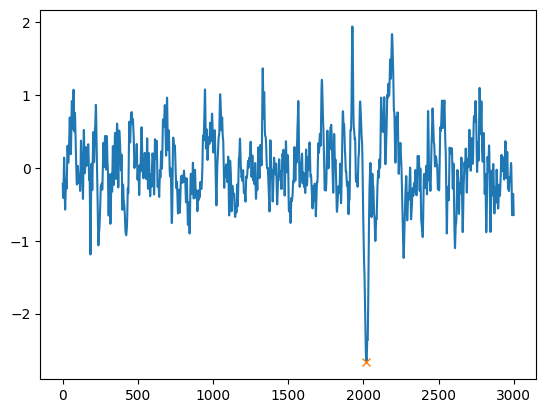

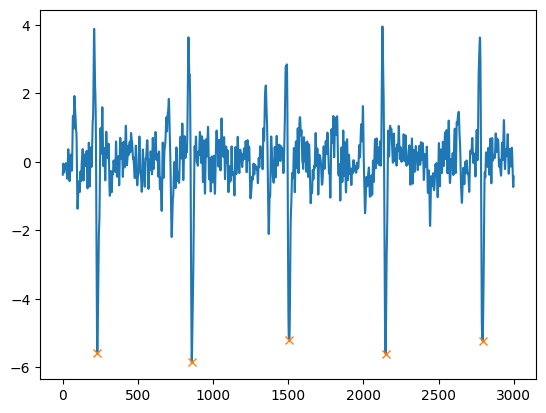

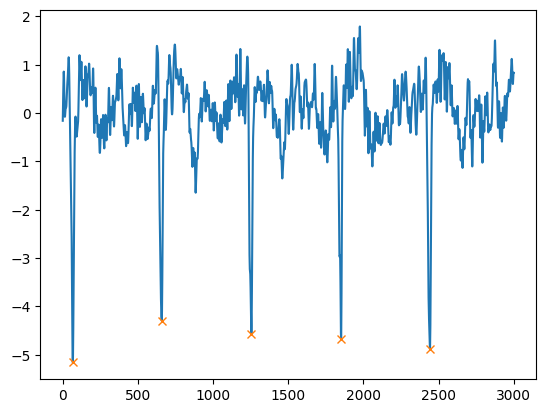

In [10]:
def determine_components(source_matrix, indices, peak_threshold = 6):
    fetal_indices = {}
    maternal_indices = {}
    for index in indices:
        candidate = source_matrix[offset:(offset+span), index]
        peaks, properties = find_peaks(np.abs(candidate), prominence = 2, distance = 400) 
        plt.figure()
        plt.plot(candidate)
        plt.plot(peaks, candidate[peaks], "x")
        print(f"for candidate {index}, found number of peaks {len(peaks)}")
        if len(peaks) > peak_threshold:
            fetal_indices[index] = peaks
        else:
            maternal_indices[index] = peaks
            
    return fetal_indices, maternal_indices

fet, mat = determine_components(S_, f_m_indices, peak_threshold = 5)
print(f"found maternal indices: {mat} and found fetal indices {fet}")

### Block 4: Eleminating directly the fetal components from the mixing matrix obtained from previous block
This part is a bit problematic since fetal components can also include maternal interference

In [ ]:
A_maternal = deepcopy(A_)
for fet_index in fet.keys():
        A_maternal[:, fet_index] = 0

### Block 5: from Block 3, we get the maternal components but we should eleminate the fetal parts in maternal so that in the subtraction part we don't substract any fetal part.

In [ ]:
from scipy.interpolate import CubicSpline

def upDownSample(source_matrix, maternal_indices, downsample_factor_qrs=10, downsample_factor_other=40):
    maternal_matrix = deepcopy(source_matrix)

    for index in maternal_indices.keys():
        candidate = maternal_matrix[offset:(offset+span), index]
        peak_indices = maternal_indices[index]
        
        # Create a mask for downsampling
        downsample_mask = np.zeros_like(candidate, dtype=bool)
        
        for peak in peak_indices:
            start_qrs = max(0, peak - 50)
            end_qrs = min(len(candidate), peak + 50)
            downsample_mask[start_qrs:end_qrs] = True
        
        # Downsample
        downsampled_signal = []
        indices = []
        for i in range(len(candidate)):
            if downsample_mask[i]:
                if i % downsample_factor_qrs == 0:
                    downsampled_signal.append(candidate[i])
                    indices.append(i)
            else:
                if i % downsample_factor_other == 0:
                    downsampled_signal.append(candidate[i])
                    indices.append(i)
        
        # Convert to numpy arrays
        downsampled_signal = np.array(downsampled_signal)
        indices = np.array(indices)
        
        # Perform cubic spline interpolation
        cs = CubicSpline(indices, downsampled_signal)
        upsampled_signal = cs(np.arange(len(candidate)))
        
        # Replace the original signal with the upsampled signal
        maternal_matrix[offset:(offset+span), index] = upsampled_signal
    
    return maternal_matrix

maternal_matrix = upDownSample(S_, mat)

fig, ax = plt.subplots(maternal_matrix.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(maternal_matrix.shape[1]):
    ax[j].plot(maternal_matrix[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

### Block 6: now having maternal_matrix, which are the maternal source components, S_maternal, we can construct the maternal channels by using the mixing matrix with fetal components deleted

In [ ]:
reconstructed_maternal = np.dot(maternal_matrix, A_maternal.T)

fig, ax = plt.subplots(reconstructed_maternal.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(reconstructed_maternal.shape[1]):
    ax[j].plot(reconstructed_maternal[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

In [ ]:
onlyFetal = filtered_data[5000:,1:] - reconstructed_maternal

fig, ax = plt.subplots(onlyFetal.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(onlyFetal.shape[1]):
    ax[j].plot(onlyFetal[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

In [ ]:
plt.plot(savgol_filter(onlyFetal[offset+300:(offset + 500), 20],25,3))

In [ ]:
ms2s = lambda x, _:f'{x/1000:g}' 
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))

components_hos = np.zeros_like(onlyFetal)
for channel in range(onlyFetal.shape[1]):
    beat, detect = apply_hosd(onlyFetal[:,channel], window_size) 
    components_hos[:,channel] = detect


In [ ]:
fig, ax = plt.subplots(onlyFetal.shape[1], 1, sharex=True, figsize=(18 / 2.54, 36 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(onlyFetal.shape[1]):
    ax[j].plot(components_hos[offset:(offset + span), j], label=f"{stats.kurtosis(components_hos[offset:(offset + span), j]):.2f}")
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()